# Tutorial Delft3D FM 1D2D fluvial flood model of Magdalena river 

This notebook is an introduction on how to use [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) functionalities to create and adjust a Delft3D FM Suite 1D2D fluvial flood model of the Magdalena river in Columbia. First a 1D river model of the Magdalena river and Canal del Dique will be created, shown in the left figure. This model will be extended with a 2D Flexible Mesh, whereafter a MERIT DTM will be added to the model in order to mimic the fluvial flood patterns. Running the model or importing the model in the Delft3D FM Suite 1D2D is not part of the exercise.  

<p align="center">
  <img alt="Light" src="figures/1D_model.png" width="45%" >
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Dark" src="figures/1D2D_model.png" width="45%">
</p>

Note that the model and tutorial are created for educational purposes and consist partially of fictive/unvalidated model data. 

<hr style="border-style: dotted;" />

 ```HYDROLIB-core``` is the core library of Python wrappers around the D-HYDRO Suite 1D2D model files (input and output) and model engines (kernel libraries). ```HYDROLIB``` is a Python package with tools for pre-processing, post-processing and analysis of hydrodynamical data and simulation results, currently focused on Delft3D Suite 1D2D. [HYDROLIB](https://github.com/Deltares/HYDROLIB) builds upon the basic HYDROLIB-core functionalities.

<hr style="border-style: dotted;" />

The goal of this tutorial is to familiarize modelers with how to apply HYDROLIB-core functionalities in their modelling procedures for building new models or adjusting existing models. As mentioned above, you will create an 1D2D fluvial flood model from scratch using the ```D-Flow FM``` HYDROLIB-core functionalities and the underlying function from mesh generation ([MeshKernelPy](https://github.com/Deltares/MeshKernelPy)). The building of the model is done by the following steps

1. Loading libraries
1. Connect to data folder
1. Create empty D-Flow FM model 
3. Read branches
4. Create computational grid
5. Add cross-sections
6. Add roughness
7. Add initial conditions
8. Add a weir to the model
9. Save 1D model
10. Create 2D flexible mesh
11. Add 2D DTM to model
12. Generate 1D2D links
13. Save 1D2D model

Note that HYDROLIB-core also contains functionalities to setup lumped rainfall runoff models (```D-RR```) and to apply real-time control at structures (```D-RTC```), but these are not covered in this tutorial.
### Installation
To run this notebook a simple Python environment with the following packages is required:
```
  - python=3.9
  - pandas
  - geopandas
  - pyogrio 
  - matplotlib
  - numpy
  - jupyter
  - xarray
  - openpyxl
  - pip
  - pip:
    - hydrolib-core==0.3.1
    - meshkernel==1.0.0

```
Note that all participants received an e-mail to download the material from the Deltares download portal and to create a [Conda](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#) environment with the packages automatically installed from ```environment.yml```. Furthermore, a dummy model is provided at the download portal to test the  environment.

### Tips for working in the Jupyter Notebook:

  * __Tab__: Auto-complete on code
  * __Ctrl__+__Enter__: Run cell 
  * __Shift__+__Enter__: Run cell and move to next cell 
  * __Ctrl__+__Shift__+__P__: Open command palette

Let's get started!

## Loading libraries
Several Python packages are required to run the notebook. These packages are imported below. Please consult the [HYDROLIB-core documentation](https://deltares.github.io/HYDROLIB-core/latest/) if you want to import additional HYDROLIB-core functionalities later. The import of HYDROLIB-core packages will be simplied in future HYDROLIB-core release (> 0.3.1)

In [21]:
# basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I/O
from pathlib import Path

# vector/polygon packages
import geopandas as gpd
from shapely import wkt
from shapely.geometry import box

# HYDROLIB-core libraries
from hydrolib.core.io.mdu.models import FMModel, AutoStartOption
from hydrolib.core.io.net.models import *
from hydrolib.core.io.crosssection.models import CrossLocModel, CrossDefModel, CrossSection, YZCrsDef
from hydrolib.core.io.friction.models import *
from hydrolib.core.io.inifield.models import *
from hydrolib.core.io.onedfield.models import *
from hydrolib.core.io.structure.models import Weir, FlowDirection, StructureModel


## Connect to data
The data for this tutorial is provided via the download portal. 

__EX1__: Change the ```inputdir``` to the path of your unzipped data folder.

In [22]:
# Get the directory of the notebook location
root = Path.cwd()

# Answer EX1
# Specify the path to the data folder
inputdir = root / 'data'
inputdir = Path(r"c:\checkouts\HYDROLIB-data_git\magdalena")


## Create empty D-Flow FM model

To start a model from scratch you need to create first an empty model without data and assign a filepath to the model. In this case a D-Flow FM model is created. The MDU file (master definition file) is the main file of the D-Flow FM model. This is created with the [```FMModel()```](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/mdu/#hydrolib.core.io.mdu.models.FMModel) function.
The `fm` model object is only created in memory. To save the actual model file, call `fm.save()`.

__EX2__: Set the ```outputdir``` of the model and give it a name. Verify that an MDU file has been written in your output directory.

In [24]:
# Create empty D-Flow FM model
fm = FMModel()

# Answer EX2
# Assign filepath to the D-Flow FM model
outputdir = root / '1D_model'
fm.filepath = outputdir / 'Magdalena_1D.mdu'
fm.save()

## PART 1: Set up a 1D Delft3D FM model
In this part we will build up the complete 1D model schematization step by step. At the end you should have a complete set of model input files for a 1D calculation.

## Read branches
The model will include the lower part of the Magadalena from Cordoba Teton to the river mouth Baranquilla and the Canal del Dique.

__EX2__: Please investigate the ```branches``` variable and answer the following questions for yourself:
* How many river branches does the model have?
* What are their names?
* Which friction type and values are used for each branch?


In [25]:
# Read the branches
branches = gpd.read_file(filename = inputdir / 'branches_Branches.shp')

# Answer EX3
print(branches.head()) # To show the first part of the dataframe 
print(branches.Name) # To get the names of the branches 
# The model consist of 3 branches
# The names of these branches are Channel_1D_1_A, Channel_1D_1_B and Channel_1D_1.
# Manning is used as friction type. Branches Channel_1D_1_B and Channel_1D_1 have a friction value of 0.02. Branch Channel_1D_1_A has a value of 0.03. 

             Name  BridgeCount  CrossSectio  CulvertCoun  GateCount  \
0  Channel_1D_1_A            0            0            0          0   
1  Channel_1D_1_B            0            0            0          0   
2    Channel_1D_1            0            0            0          0   

     GeometryLen IsLengthCus  LateralSour         Length LongName  \
0   99845.093077           F            0  101023.779052     None   
1  111429.230469           F            0  113923.354861     None   
2  117327.933796           F            0  116641.023471     None   

   OrderNumber  PumpCount   Source  StructureCo   Target  WeirCount fric_type  \
0           -1          0  Node001            0  Node003          0   Manning   
1           -1          0  Node003            0  Node002          0   Manning   
2           -1          0  Node003            0  Node005          0   Manning   

   fric_value  chainage                                           geometry  
0        0.03    1000.0  LINESTRING 

## Create 1D computational grid

In the previous step you read the geometry and attributes of the branches into the notebook. These branches will become the ***network*** input to our `FMModel`. The cell below shows how the geometry and name of the branches are assigned to the network. In addition a 1D computational grid (````mesh1d````) with gridpoint every 1000 meter is created on top of this network. 

Since the network does not yet exist, you need to create an empty [network model](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/net/). Assign the geometry of the branches followed by the generation of the computational grid. The network model should be added to the D-Flow FM model (``fm`` variable in this notebook) as ```network``` in the ```netfile``` parameter in the section ```geometry```. Note that you have to specify a filepath for the networkfile.  

Note that the network model can consist of 1D, 2D flexible mesh (```mesh2d```) and 1D2D links (```links1d2d```). 

In [28]:
# Specify 1D computational grid distance
dx = 1000.0

# Create an empty network
network = Network()

# Assign geometry of the branches and generate the computational grid on top of the branches.
for index,branch in branches.iterrows():
    xy = np.transpose(branch.geometry.xy)
    branch_new = Branch(geometry=xy) 
    branch_new.generate_nodes(mesh1d_edge_length=dx)
    network.mesh1d_add_branch(branch_new, name=branch.Name)

# Assign the 1D network with 1D mesh to the D-Flow FM model and specify filepath
fm.geometry.netfile.network = network
fm.geometry.netfile.filepath = "FlowFM_net.nc"


__EX3__: Please change the computational grid distance of each branch accordingly:

| **Branch name** | **dx [m]** |
|-----------------|------------|
| Channel_1D_1_A  | 1000       |
| Channel_1D_1_B  | 1000       |
| Channel_1D      | 500        |

_Tip_: Do not forget to create a new network.

In [82]:
# Answer EX3

# Specify 1D computational grid distance
dx = [1000., 1000., 500.]

# Create an empty network
network = Network()

# Assign geometry of the branches and generate the computational grid on top of the branches.
for index,branch in branches.iterrows():
    xy = np.transpose(branch.geometry.xy)
    branch_new = Branch(geometry=xy) 
    branch_new.generate_nodes(mesh1d_edge_length=dx[index])
    network.mesh1d_add_branch(branch_new, name=branch.Name)
network._mesh1d._set_mesh1d()

# Assign the 1D network with 1D mesh to the D-Flow FM model and specify filepath
fm.geometry.netfile.network = network
fm.geometry.netfile.filepath = "FlowFM_EX3_net.nc"

The 1D branches are plotted on a map in the figure below.
Also, the computational grid points in the `mesh1d` definition are shown.

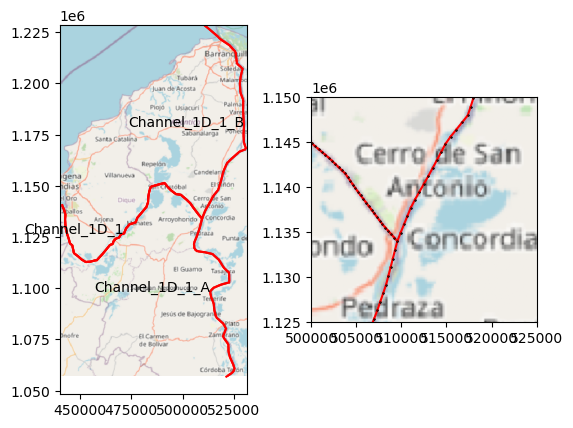

In [84]:
# Create a figure with the flowlinks of the model
figure, (ax1, ax2) = plt.subplots(ncols=2)
img = plt.imread(inputdir/"osm_background.png")
mesh1d_meshkernel = network._mesh1d._get_mesh1d()

ax1.imshow(img, extent=[440000,531544.97964175534434617 ,1057000 ,1228644.01383191486820579 ])
mesh1d_meshkernel.plot_edges(ax=ax1, color='red')

# Add some annotation of branches:
for index,branch in branches.iterrows():
    middleIndex = int((len(branch['geometry'].coords) - 1)/2)
    ax1.text(branch['geometry'].xy[0][middleIndex], branch['geometry'].xy[1][middleIndex], branch['Name'], ha='right')

# Make a second plot with a zoom-in view of the computational grid points near the junction
ax2.imshow(img, extent=[440000,531544.97964175534434617 ,1057000 ,1228644.01383191486820579 ])
ax2.set_xlim([500000, 525000])
ax2.set_ylim([1125000 ,1150000])
mesh1d_meshkernel.plot_edges(ax=ax2, color='red',marker='.',markeredgecolor='k',markersize=1)



## Add cross-sections

In order to determine the flow area of the 1D model during the computation, you need cross-sections. These cross-sections consist of two components: 
1. __Cross-section locations__ (```crosslocfile```):
The crosslocfile contains the location of the cross-section on the branches. This is indicated with ```branchId chainage```, where branchId is the name of the branch  and chainage the distance to the upstream node. The figure below shows the cross-section locations in grey. In addition the cross-section location consist of the ```cross-section definition``` used at that location and a vertical ```shift``` of the profile. The latter is mainly used to create a good longitudinal slope over the 1D model (in case of shared cross-sections).
<p align="center">
<img alt="Light" src="figures/crosloc.png" width="80%" >
<p\>

2. __Cross-section definitions__ (```crossdeffile```): The crossdeffile has the cross-section definitions in it. These definitions describe the shape of the profile. There are multiple types available: circle, rectangle, ZW- (tabulated), YZ- and XYZ-profiles. Depending on what type of watersystem you try to model you decide which cross-section to use. We recommend to use ZW- or YZ-profiles for rivers. 
<p align="center">
<img alt="Light" src="figures/crsdef.png" width="40%" >
<p\>



### Add cross-section locations
Below the cross-section locations are read from a CSV-file and added to an empty [CrossLocModel](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/crosssection/#hydrolib.core.io.crosssection.models.CrossLocGeneral). Note that the entire dataframe with the cross-section locations is converted at once to CrossLocModel. More about dataframa handling in HYDROLIB-core can be found [here](https://deltares.github.io/HYDROLIB-core/0.3.1/tutorials/dataframe_handling/).

__EX4__: 
Please investigate the ```profile_loc``` variable and answer the following questions for yourself:
* How many cross-sections are there in the model and per branch?
* Check the chainage. 

Also print the cross-sections locations assigned to the D-Flow FM model. Use ```fm.geometry.crosslocfile.crosssection```. 
* What happens if you only print the first ```fm.geometry.crosslocfile```

In [73]:
# Read profile location file
profiles_location_file = inputdir / 'cross_section_locations.csv'
profiles_loc = pd.read_csv(profiles_location_file, index_col=False)

# Answer EX4  - part 1
print(profiles_loc.head())
# There are 6 cross-sections in the model with 2 cross-sections per branch. 
# The chainage of the cross-sections indicate that the profiles are located upstream and downstream of the branch.

# Create empty cross-section location model
crsloc = CrossLocModel()

# Assign filepath to the model
crsloc.filepath = 'crsloc.ini'

# Convert the dataframe
crsloc.crosssection = profiles_loc.to_dict("records")

# Assign CrossLocModel to the D-Flow FM model.
fm.geometry.crosslocfile = crsloc

# Answer EX4 - part 1
print(fm.geometry.crosslocfile.crosssection)
print(fm.geometry.crosslocfile) # You only get filepath relatively to the MDU-file. 

 



              id        branchId  chainage  shift       definitionId
0  CrossSection1  Channel_1D_1_A      1000      0  CrossSection_1D_1
1  CrossSection2  Channel_1D_1_A     95000      0  CrossSection_1D_2
2  CrossSection3  Channel_1D_1_B      1000      0  CrossSection_1D_3
3  CrossSection4  Channel_1D_1_B     95000      0  CrossSection_1D_4
4  CrossSection5    Channel_1D_1      1000      0  CrossSection_1D_5
[CrossSection(comments=Comments(id='Unique cross-section location id.', branchid='Branch on which the cross section is located.', chainage='Chainage on the branch (m).', x='x-coordinate of the location of the cross section.', y='y-coordinate of the location of the cross section.', shift='Vertical shift of the cross section definition [m]. Defined positive upwards.', definitionid='Id of cross section definition.'), id='CrossSection1', branchid='Channel_1D_1_A', chainage=1000.0, x=None, y=None, shift=0.0, definitionid='CrossSection_1D_1', locationtype=<LocationType.oned: '1d'>), Cr

### Add cross-section definitions

In the following cell the definitions belonging to the cross-section locations are added to the D-Flow FM model. These cross-sections are all YZ-profiles in order to define natural shape of the river. 

Please see that the following steps are included:
1. Read the cross-section definitions from an excel. Note that the cross-section definitions id's match with the definitions specified in the crossLocModel.
2. Create an empty [CrossDefModel](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/crosssection/#hydrolib.core.io.crosssection.models.CrossDefModel) and assign filepath
3. Specify some characteristics for YZ profile. Please consult [appendix C.16.1.6 from D-Flow FM 1D2D](https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual_1D2D.pdf)
4. Create [YZCrsDef](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/crosssection/#hydrolib.core.io.crosssection.models.YZCrsDef) for each profile definition.
5. Append the definition to the CrossDefModel.
6. Append the CrossDefModel to the D-Flow FM model.


In [89]:
# Create cross-section definitions
profiles_file = inputdir / '1D_YZ_CrossSections.xlsx'

profiles = pd.read_excel(profiles_file, sheet_name=None)
names = list(profiles.keys())
print(names)

# Create empty CrossDefModel
crsdef = CrossDefModel()
crsdef.filepath = 'crsdef.ini'

# Specify some charachteristics for YZ profile
type_crs = 'yz'
thalweg = 0.0
singleValued = 'yes'
conveyance = 'segmented'
sectionCount = 1

# Create the YZ profiles and append them to the CrossDefModel
for name in names:
    yzCount = len(profiles[name].values)
    ycoord = profiles[name].y.to_list()
    zcoord = profiles[name].z.to_list()
    frictionIds = 'channels'
    frictionPositions = [profiles[name].y[0], profiles[name].y[yzCount-1]]

    crosssection = YZCrsDef(id=name, 
        type=type_crs, 
        thalweg=thalweg, 
        singleValuedZ=singleValued, 
        conveyance=conveyance,
        yzCount=yzCount, 
        yCoordinates= ycoord, 
        zCoordinates=zcoord,
        sectionCount=sectionCount,
        frictionIds = frictionIds,
        frictionPositions=frictionPositions)
    
    crsdef.definition.append(crosssection)
    print(f'definition of {name} added to cross-section model')

# Append CrossDefModel to D-Flow FM model
fm.geometry.crossdeffile = crsdef


['CrossSection_1D_1', 'CrossSection_1D_2', 'CrossSection_1D_3', 'CrossSection_1D_4', 'CrossSection_1D_5', 'CrossSection_1D_6']
definition of CrossSection_1D_1 added to cross-section model
definition of CrossSection_1D_2 added to cross-section model
definition of CrossSection_1D_3 added to cross-section model
definition of CrossSection_1D_4 added to cross-section model
definition of CrossSection_1D_5 added to cross-section model
definition of CrossSection_1D_6 added to cross-section model


## Add roughness

The 1D model has now a network topology, computational 1D grid and cross-sections. Friction is a component that should be added to the model to get the proper bed roughness and channel conveyance.

In this step you will add the [FrictionModel](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/friction/#hydrolib.core.io.friction.models.FrictionModel) to the D-Flow FM model by specifying the friction type and value at the upstream cross-section location (chainage=1000.0 m) of each branch in the model ([FrictBranch](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/friction/#hydrolib.core.io.friction.models.FrictBranch)). Also a global roughness section is specified ([FrictGlobal](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/friction/#hydrolib.core.io.friction.models.FrictGlobal)). This global section is used when there is no friction type and values specified for a specific branch. It also contains the frictionId. In the cross-section definition model a reference is made to this frictionId. You can check this with the commands below and search for ```frictionIds```.

In [90]:
# Print directly the modelobject (in this case all definitions)
print(fm.geometry.crossdeffile.definition)

# Or convert it first to a dataframe
df_def = pd.DataFrame([f.__dict__ for f in fm.geometry.crossdeffile.definition])
print(df_def[['frictionids']])

[YZCrsDef(comments=Comments(id='Unique cross-section definition id.', thalweg='Transverse Y coordinate at which the cross section aligns with the branch (Keyword used by GUI only).', type='Cross section type; must read yz', conveyance='lumped: Lumped, segmented: Vertically segmented. Only the default lumped option is allowed if singleValuedZ = no. In the case of lumped conveyance, only a single uniform roughness for the whole cross section is allowed, i.e., sectionCount must equal 1.', yzcount='Number of YZ-coordinates.', yCoordinates='Space separated list of monotonic increasing y-coordinates [m].', zCoordinates='Space separated list of single-valued z-coordinates [m AD].', sectioncount='Number of roughness sections. If the lumped conveyance is selected then sectionCount must equal 1.', frictionpositions='Locations where the roughness sections start and end. Always one location more than sectionCount. The first value should equal 0 and the last value should equal the cross section len

Note that YZ profiles can refer to multiple frictionIds, since the friction can vary over the cross-section. Hence the frictionId is given in a ```List()```. This means indirectly that multiple FrictionModels can be added to one D-Flow FM model. The created FrictionModel should therefore been added in a ```List()``` to the D-Flow FM model.

In [91]:
# Specify frictionId(s) for the FrictionModel(s)
friction_name = 'channels'

# Specify for each FrictionModel a global type and value
global_type = FrictionType.manning # Options are chezy,debosbijkerk, manning, strickler, stricklernikuradse, wallawnikuradse, whitecolebrook
global_value = 0.023

# Create empty friction model and assign filepath
roughness = FrictionModel()
roughness.filepath = "roughness-channels.ini" # often we specify the filenames as "roughness-frictionId.ini"

# Create global friction model and add it to frictionmodel
roughness.global_ = FrictGlobal(frictionId=friction_name,frictionType=global_type,frictionValue=global_value)

# Add friction from branches
function_type = 'constant' # This model uses constant friction per branch

df_friction = branches[['Name', 'fric_type', 'fric_value', 'chainage']]
df_friction.columns = ['branchId','frictionType','frictionValues', 'chainage']
df_friction = df_friction.assign(frictionValues = [[i] for i in df_friction.frictionValues.values])
df_friction = df_friction.assign(functionType=function_type)
df_friction = df_friction.assign(chainage = [[i] for i in df_friction.chainage.values])
df_friction = df_friction.assign(numlocations=1) # you can specify multiple location along the branch with different friction values.


roughness.branch = df_friction.to_dict('records') # the dataframe is converted to FrictBranch models at once 

# Add frictionmodel to the D-Flow FM model.
fm.geometry.frictfile = [roughness] # frictfile is a list of frictionModels

__EX5__: Let's build another frictionmodel with frictionId  _dique_ representing the friction in Canal del Dique. This frictionmodel assumes Chezy as global friction type and has friction value of 45.

In [92]:
# Answer to EX5
# Specify frictionId(s) for the FrictionModel(s)
friction_id2 = 'dique'

# Specify for each FrictionModel a global type and value
global_type2 = FrictionType.chezy
global_value2 = 45.0


# Create empty friction model and assign filepath
roughness_dique = FrictionModel()
roughness_dique.filepath = 'roughness-dique.ini'

# Create global friction model and add it to frictionmodel
roughness_dique.global_ = FrictGlobal(frictionId=friction_id2,frictionType=global_type2,frictionValue=global_value2)

# Add frictionmodels to the D-Flow FM model.
fm.geometry.frictfile = [roughness, roughness_dique] # Note that the other friction needs to be added to the list.  

The cross-sections on the Canal del Dique (Channel_1D_1) do not refer to this new frictionId. Please uncomment the code below to change this after completion of exercise 5.

In [93]:
# Convert crosssection defintions from D-Flow FM model to dataframe
#df_def = pd.DataFrame([f.__dict__ for f in fm.geometry.crossdeffile.definition])
#print(df_def)

# Check which cross-section locations are located on Channel_1D_1 
#df_loc = pd.DataFrame([f.__dict__ for f in fm.geometry.crosslocfile.crosssection])
#print(df_loc.loc[:,['id','branchid','definitionid']])

# To which definition do these locations refer:
#defs = df_loc.loc[df_loc.index[df_loc.branchid=='Channel_1D_1'],'definitionid'].values

# Change the Frictionids to dique for Channel_1D_1
#index_defs = df_def.index[df_def.id.isin(defs)]

#for i in index_defs:
#    df_def.loc[i, 'frictionids'] = ['dique']

# Overwrite the definitions in D-Flow FM model with the changes in the dataframe
#fm.geometry.crossdeffile.definition = df_def.to_dict("records")

## Add boundary conditions to the model
@Arthur, this I still need to add. 

## Add initial conditions
For this model an initial water depth of 1.0 meter is assumed in the 1D model. 

Below you can see how this initial waterdepth is added to the D-Flow FM model using the following steps:
1. Creating 1D initial conditions field ([1DField](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/onedfield/)), which contains the actual waterdepths on each branch. Note that the file is seperately saved from the rest of the model.
2. Creating [IniFieldModel](https://deltares.github.io/HYDROLIB-core/0.3.1/reference/inifield/) (= Initial and parameter field files) in which we collect the initial condition specified in step 1, so that it can be added to the `FMModel`. 

In [94]:
# Create 1D initial conditions field
ini_1d = OneDFieldModel()
ini_1d.global_ = OneDFieldGlobal(quantity='waterdepth', unit='m', value=1.0) # only global values are needed in this case, but you could also specify it per branch.
ini_1d.filepath = 'initialwaterdepth.ini'
ini_1d.save(outputdir / ini_1d.filepath) # 1D field ini files needs to be saved seperately from the model save. 

# Create initial field file
ini_field = IniFieldModel()
ini_field.filepath = 'inifield.ini'
ini_field.initial = InitialField(quantity='waterdepth',datafile=ini_1d.filepath, datafiletype=DataFileType.onedfield)
fm.geometry.inifieldfile = ini_field


## Add a weir to the model
Many lakes occur close along Canal del Dique. See figure below. This tutorial assumes that these lakes can function as extra storage for the floods from the river. Hence a weir structure, functioning as a small dam, is added downstream of the lakes. This weir structure has the following conditions:
* It is located at 70 km from the upstream node of the branch. 
* The crestlevel is 4.0 m AD.
* The crest width is 105.0 m. 
* The flow over the dam is in both directions. 

<p align="center">
<img alt="Light" src="figures/multiple_lakes.png" width="40%" >
<p\>

In [95]:
# Create weir structure
weir = Weir(
    id='fictive_dam', 
    name = 'fictive_dam',
    branchId='Channel_1D_1', 
    chainage=70000.0, 
    allowedFlowDir=FlowDirection.both, 
    crestLevel=4.0, 
    crestWidth=105.0, 
    corrCoeff=1.000, 
    useVelocityHeight=True
)

# Create structure model
struc = StructureModel()
struc.filepath = 'structure.ini'

# Append weir to structure
struc.structure.append(weir)

# Assign structure model to D-Flow FM model
fm.geometry.structurefile = [struc]



__EX6__: You found out that the dam should be significantly higher. Hence you increase the crestlevel to 10.0 m AD. Your client also decided that flow can only occur from upstream to downstream. Please change the weir above. 

In [ ]:
# Answer EX6: 

# Create weir structure
weir = Weir(
    id='fictive_dam', 
    name = 'fictive_dam',
    branchId='Channel_1D_1', 
    chainage=70000.0, 
    allowedFlowDir=FlowDirection.positive, 
    crestLevel=10.0, 
    crestWidth=105.0, 
    corrCoeff=1.000, 
    useVelocityHeight=True
)

# Create structure model
struc = StructureModel()
struc.filepath = 'structure.ini'

# Append weir to structure
struc.structure.append(weir)

# Assign structure model to D-Flow FM model
fm.geometry.structurefile = [struc]

## Save 1D model

The 1D model is now finished. The commands below are used to save the model to the correct filepath (specified for the MDU-file). Note that the ```recurse``` is set to ```True``` to make sure all underlying model files are written to the directory. Else the MDU-file will be the only file written to the directory.

In [96]:
# Save the 1D model. 
fm.general.autostart = AutoStartOption.no # This is a workaround for a bug in hydrolib-core 0.3.1
fm.save(recurse=True)

## PART 2: Extend to a 1D2D Delft3D FM model
We will now continue with the model `fm` from part 1, and add a 2D mesh to it, as well as 1D2D couplings.

## Create 2D flexible mesh
We use a shapefile with the area of interest to define the extent of the new 2D mesh that is to be generated.
First, a uniform rectilinear mesh is generated, after which it can be locally refined.

In [116]:
gdf_grid = gpd.read_file(inputdir / 'outline_2D_grid.shp')

extent = gdf_grid.geometry[0].bounds

# Step 1: uniform rectilinear mesh
# EX.. Start with a new Mesh2d and find the method that generates a rectilinear mesh
mesh2d = Mesh2d()
mesh2d.create_rectilinear(
    extent=extent, 
    dx=2500.0,
    dy=2500.0
)

# Step 2: clip resulting mesh within polygon area of interest
# Prepare a clipping polygon for MeshKernel input:
clip_polygon = np.array(gdf_grid.geometry[0].exterior.xy)
clip_geom = GeometryList(clip_polygon[0],clip_polygon[1])

# EX... Use the `clip()` function to crop the recilinear mesh to the area of interest
# mesh2d.clip(clipgeom)
mesh2d.clip

# Step 3: Refine the coarse uniform grid in a buffer region around the rivers
gdf_refine = gpd.read_file(inputdir / 'buffer_around_river_proj.shp')
refine_polygon = np.array(gdf_refine.geometry[0].exterior.xy)
mesh2d.refine(GeometryList(refine_polygon[0], refine_polygon[1]), level=1)

fm.geometry.netfile.network._mesh2d = mesh2d
fm.geometry.netfile.filepath = "FlowFM_1D2D_net.nc"


The cell below produces a basic plot of the 1D + 2D mesh.

### Local refinement of the 2D mesh

In [ ]:
mesh2d = Mesh2d()
mesh2d.create_rectilinear(
    extent=extent, 
    dx=2500.0,
    dy=2500.0
)

# Step 2: clip resulting mesh within polygon area of interest
# Prepare a clipping polygon for MeshKernel input:
clip_polygon = np.array(gdf_grid.geometry[0].exterior.xy)
clip_geom = GeometryList(clip_polygon[0],clip_polygon[1])

# EX... Use the `clip()` function to crop the recilinear mesh to the area of interest
# mesh2d.clip(clipgeom)
mesh2d.clip  ## RINSKE: hier verder

# Step 3: Refine the coarse uniform grid in a buffer region around the rivers
gdf_refine = gpd.read_file(inputdir / 'buffer_around_river_proj.shp')
refine_polygon = np.array(gdf_refine.geometry[0].exterior.xy)
mesh2d.refine(GeometryList(refine_polygon[0], refine_polygon[1]), level=1)


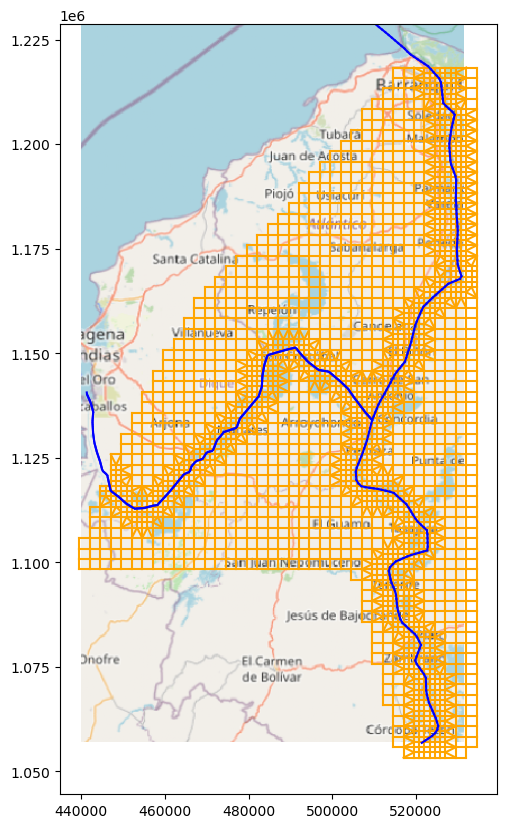

In [117]:
mesh2d_mk = network._mesh2d.get_mesh2d()
mesh1d_mk = network._mesh1d._get_mesh1d()

figure, ax = plt.subplots()
ax.set_aspect('equal')
plt.rcParams["figure.figsize"]=10,10

ax.imshow(img, extent=[440000,531544.97964175534434617 ,1057000 ,1228644.01383191486820579 ])
# Plot the 1D2D network
mesh2d_mk.plot_edges(ax=ax, color="orange")
mesh1d_mk.plot_edges(ax=ax, color='blue')

#link1d2d_meshkernel.plot_edges(ax, mesh1d_mk, mesh2d_mk, color="green")

## Generate 1D2D links


In [243]:
links1d2d = Link1d2d()

node_mask = network._mesh1d.get_node_mask()
#polygon = network.meshkernel.mesh2d_get_mesh_boundaries_as_polygons()
#print(polygon)
#face2d = np.stack([network._mesh2d.mesh2d_face_x, network._mesh2d.mesh2d_face_y], axis=1)
#multipoint = GeometryList(x_coordinates=face2d[:,0],y_coordinates=face2d[:,1])

# Determine maximum bounds
network = fm.geometry.netfile.network
# If not provided, create a box from the maximum bounds
xmin = min(network._mesh1d.mesh1d_node_x.min(), network._mesh2d.mesh2d_node_x.min())
xmax = max(network._mesh1d.mesh1d_node_x.max(), network._mesh2d.mesh2d_node_x.max())
ymin = min(network._mesh1d.mesh1d_node_y.min(), network._mesh2d.mesh2d_node_y.min())
ymax = max(network._mesh1d.mesh1d_node_y.max(), network._mesh2d.mesh2d_node_y.max())

bbox = box(xmin, ymin, xmax, ymax)
xy = bbox.exterior.xy
within = GeometryList(xy[0],xy[1])
# network.link1d2d_from_1d_to_2d()
#links1d2d._link_from_2d_to_1d_embedded(node_mask=node_mask, points=multipoint)
#network.link1d2d_from_1d_to_2d()
#network._link1d2d.link

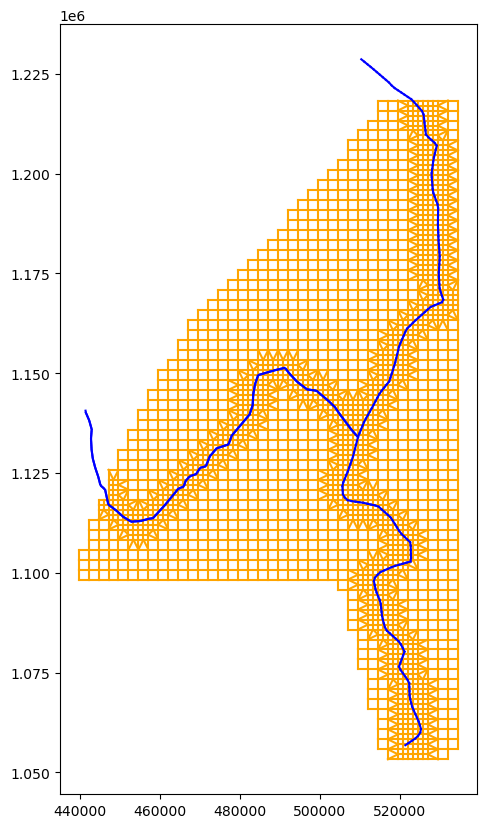

In [244]:
figure, ax = plt.subplots()
ax.set_aspect('equal')
plt.rcParams["figure.figsize"]=10,10

network._mesh1d._set_mesh1d()
network._mesh2d._set_mesh2d()

mesh1d_mk = network._mesh1d._get_mesh1d()
mesh2d_mk = network._mesh2d.get_mesh2d()
link1d2d_mk = links1d2d.meshkernel.contacts_get()

# Plot the 1D2D network
mesh2d_mk.plot_edges(ax=ax, color="orange")
mesh1d_mk.plot_edges(ax=ax, color='blue')
#link1d2d_meshkernel.plot_edges(ax, mesh1d_mk, mesh2d_mk, color="green")

In [245]:
bedlevel_file = inputdir / '2D_MERIT_DTM.tif'


ini_field.initial.append(InitialField(
    quantity='bedlevel',
    datafile=bedlevel_file, 
    datafiletype=DataFileType.geotiff,
    interpolationmethod=InterpolationMethod.averaging,
    averagingtype=AveragingType.mean,
    operand=Operand.override,
    locationtype=LocationType.twod ))

fm.geometry.inifieldfile = ini_field

## Save 1D2D model

In [246]:
# Change fm
outputdir_1d2d = root / '1D2D_model'
fm.filepath = outputdir_1d2d / 'Magdalena_1D2D.mdu'

fm.general.autostart = AutoStartOption.no
fm.save(recurse=True)